**Summary**

Time Series forecasting tasks can be carried out following different approaches. The most classical is based on statistical and autoregressive methods. More tricky are the algorithms based on boosting and ensemble where we have to produce a good amount of useful handmade features with rolling periods. On the other side, we can find neural network models that enable more freedom in their development, providing customizable adoption of sequential modeling and much more.
Recurrent and convolutional structure achieve great success in time series forecasting. Interesting approaches in the field are given by the adoption of Transformers and Attention architectures, originally native in the NLP. Uncommon seems to be the usage of graph structures, where we have a network composed of different nodes that are related by some kind of linkage to each other. What we try to do is to use a graphical representation of our time series to produce future forecasts.

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [34]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import time
import numpy    as np
import pandas   as pd
from   tqdm     import tqdm



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split




# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow                 as tf
from   tensorflow.keras           import backend as K
from   tensorflow.keras.models    import *
from   tensorflow.keras.layers    import *
from   tensorflow.keras.callbacks import *


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from utils.PerformanceMetrics     import *
from utils.spectral_utilities     import *
from utils.spectral_gcn           import GraphConv
from utils.BLAS                   import *

# Import data

In [3]:
# Start timer
#
start = time.time()


# Load dataset
#
df = pd.read_csv('Data/sales_train.csv.zip')
print('[INFO] Dataset loaded')


# Stop timer
#
print('[INFO] Time %.2f' % (time.time() - start))


df.head()

[INFO] Dataset loaded
[INFO] Time 0.27


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Preprocess



## Convert date to datetime64

In [4]:
df['date'] = pd.to_datetime(df['date'])

## Switch data from vertical to horizontal format

In [5]:
# Switch data from vertical to horizontal format
#
unstaked_df = df.copy()
unstaked_df['id'] = df['item'].astype(str)+'_'+df['store'].astype(str)
unstaked_df.set_index(['id','date'], inplace=True)
unstaked_df.drop(['store','item'], axis=1, inplace=True)
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)


# Visualize data
#
print('[INFO] Number of stores: ', unstaked_df.index.nunique())
unstaked_df.head()

[INFO] Number of stores:  500


date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
id,,,,,,,,,,,,,,,,,,,,,
10_1,37.0,34.0,32.0,45.0,35.0,54.0,37.0,37.0,32.0,36.0,...,60.0,67.0,88.0,42.0,50.0,55.0,63.0,56.0,78.0,74.0
10_10,45.0,50.0,53.0,51.0,54.0,54.0,54.0,40.0,50.0,53.0,...,64.0,74.0,66.0,61.0,53.0,72.0,81.0,69.0,86.0,67.0
10_2,51.0,56.0,46.0,56.0,53.0,68.0,37.0,47.0,65.0,61.0,...,86.0,114.0,84.0,66.0,69.0,63.0,78.0,76.0,77.0,116.0
10_3,38.0,60.0,50.0,46.0,46.0,52.0,40.0,41.0,32.0,38.0,...,83.0,71.0,101.0,45.0,61.0,51.0,56.0,61.0,72.0,68.0
10_4,30.0,29.0,37.0,45.0,52.0,58.0,29.0,44.0,53.0,39.0,...,75.0,64.0,86.0,56.0,54.0,57.0,53.0,65.0,74.0,69.0


## Visualization

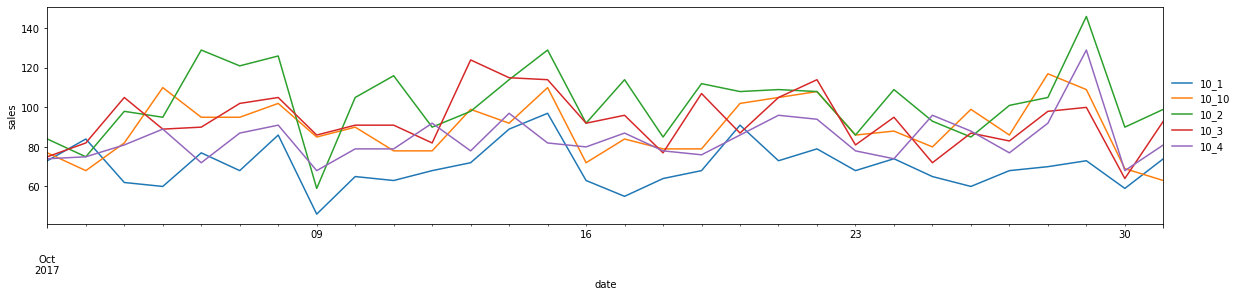

In [6]:
# Plot the sequence of sales for the first 5 stores until (Noe-2017)
#
sequence = get_timespan(unstaked_df, date(2017,11,1), 30);

sequence.head(5).T.plot(figsize=(20, 4));

plt.ylabel('sales');
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False);

# Training/Validation/Testing

In [7]:
# Parameters
#
sequence_length = 14
#
#
train_date = date(2013, 1, 1)
valid_date = date(2015, 1, 1)
test_date  = date(2016, 1, 1)

## Training data

In [8]:
X_seq, X_cor, X_feat, y = [], [], [], []
#
for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq  = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor  = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train      = np.concatenate(y, axis=0).astype('float16')

100%|██████████| 717/717 [00:46<00:00, 15.37it/s]


## Validation data

In [9]:
X_seq, X_cor, X_feat, y = [], [], [], []
#
for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq  = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor  = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid      = np.concatenate(y, axis=0).astype('float16')

100%|██████████| 352/352 [00:23<00:00, 15.04it/s]


## Testing data

In [10]:
X_seq, X_cor, X_feat, y = [], [], [], []
#
for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), date(2016,12,31))):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq  = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor  = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test      = np.concatenate(y, axis=0).astype('float16')



100%|██████████| 352/352 [00:23<00:00, 14.75it/s]


In [11]:
# print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

## Scaling

In [12]:
# Setup scalers
#
scaler_seq  = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,10)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)
X_test_seq  = scaler_seq.transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test  = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,10)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,10)).reshape(X_valid_feat.shape)
X_test_feat  = scaler_feat.transform(X_test_feat.reshape(-1,10)).reshape(X_test_feat.shape)

## Obtain Laplacians from correlations

In [13]:
### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap  = localpooling_filter(1 - np.abs(X_test_cor))

# Graph-based Model

Our model receives, as input, sequences of sales from all stores and adjacent matrixes obtained from the same sequences. The sequences are passed through LSTM layers, while the correlation matrixes are processed by GraphConvolution layers. They are implemented in Spektral, a cool library for graph deep learning build on Tensorflow. It has various kinds of graph layers available. We use the most basic one, the GraphConvolution. It operates a series of convolution operations between learnable weights, external node features (provided together with the adjacent matrix), and our correlation matrixes. Unlikely, at the moment Spektral doesn’t support Window so I have to extract manually the class of my interest and create my Python executable.

In [14]:
def Graph_Model( X_train_feat ):
    
    inp_seq = Input((sequence_length, 10))
    inp_lap = Input((10, 10))
    inp_feat = Input((10, X_train_feat.shape[-1]))

    x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
    x = GraphConv(16, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])

    return model

## Setup model

In [15]:
model = Graph_Model( X_train_feat )
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 10)]     0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 10, 32)       256         input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 14, 10)]     0                                        

## Training model

In [16]:
# Earlystopping
#
earlystopping = EarlyStopping(patience             = 5, 
                              verbose              = 2, 
                              min_delta            = 0.001, 
                              monitor              = 'val_loss', 
                              mode                 = 'auto', 
                              restore_best_weights = True)                          



# Learning rate adjustment
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                    factor      = 0.75,
                                    patience    = 10)

In [17]:
# Train a mdoel for each store using all the data available from other stores
#
pred_valid_all = np.zeros(y_valid.shape)
pred_test_all  = np.zeros(y_test.shape)



nStores = 10
#
#
for store in range(nStores):

    print('-------', 'Store', store, '-------')
    
    model = Graph_Model( X_train_feat )
    model.fit([X_train_seq, X_train_lap, X_train_feat], y_train[:,store], 
              epochs          = 100, 
              batch_size      = 256, 
              callbacks       = [earlystopping, lrs_scheduler], 
              verbose         = 1,
              validation_data = ([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:,store]))


              

    pred_valid_all[:,store] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
    pred_test_all[:,store] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid  = scaler_seq.inverse_transform(y_valid)
pred_test_all  = scaler_seq.inverse_transform(pred_test_all)
reverse_test   = scaler_seq.inverse_transform(y_test)

------- Store 0 -------
Epoch 1/100
141/141 [==============================] - 8s 53ms/step - loss: 0.3256 - mse: 0.3256 - val_loss: 0.9405 - val_mse: 0.9405 - lr: 0.0010
Epoch 2/100
141/141 [==============================] - 7s 51ms/step - loss: 0.2410 - mse: 0.2410 - val_loss: 0.7667 - val_mse: 0.7667 - lr: 0.0010
Epoch 3/100
141/141 [==============================] - 7s 50ms/step - loss: 0.2324 - mse: 0.2324 - val_loss: 0.5833 - val_mse: 0.5833 - lr: 0.0010
Epoch 4/100
141/141 [==============================] - 7s 49ms/step - loss: 0.2195 - mse: 0.2195 - val_loss: 0.5044 - val_mse: 0.5044 - lr: 0.0010
Epoch 5/100
141/141 [==============================] - 7s 51ms/step - loss: 0.1929 - mse: 0.1929 - val_loss: 0.7545 - val_mse: 0.7545 - lr: 0.0010
Epoch 6/100
141/141 [==============================] - 7s 50ms/step - loss: 0.1786 - mse: 0.1786 - val_loss: 0.3306 - val_mse: 0.3306 - lr: 0.0010
Epoch 7/100
141/141 [==============================] - 7s 51ms/step - loss: 0.1686 - mse: 0.16

# Evaluation

In [35]:
RMSE     = {}
R2_score = {}
SMAPE    = {}
#
for store in range( nStores ):
    
    RMSE[store]     = np.sqrt(rmse(reverse_test[:,store], pred_test_all[:,store]))
    R2_score[store] = np.sqrt(R2(reverse_test[:,store], pred_test_all[:,store]))
    SMAPE[store]    = np.sqrt(smape(reverse_test[:,store], pred_test_all[:,store]))

## RMSE

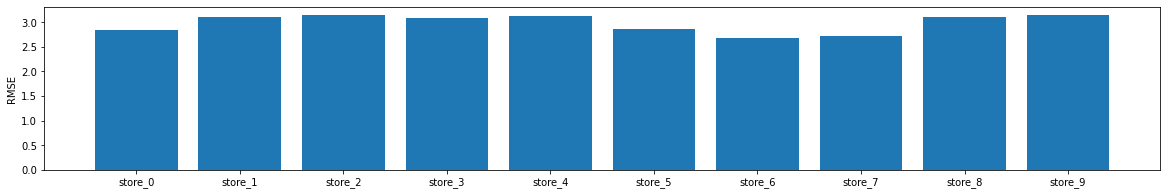

In [36]:
plt.figure(figsize=(20, 3))

plt.bar(range(nStores), RMSE.values())
plt.xticks(range(nStores), ['store_'+str(s) for s in range(nStores)])
plt.ylabel('RMSE')
np.set_printoptions(False)

## R2

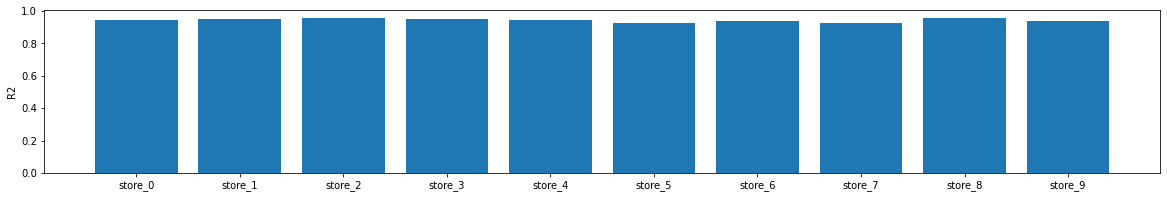

In [38]:
plt.figure(figsize=(20, 3))

plt.bar(range(nStores), R2_score.values())
plt.xticks(range(nStores), ['store_'+str(s) for s in range(nStores)])
plt.ylabel('R2')
np.set_printoptions(False)

## SMAPE

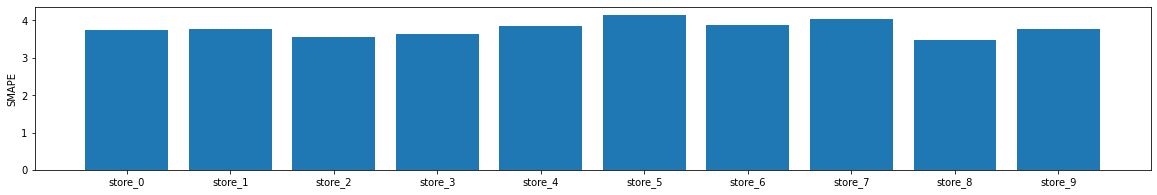

In [39]:
plt.figure(figsize=(20, 3))

plt.bar(range(nStores), SMAPE.values())
plt.xticks(range(nStores), ['store_'+str(s) for s in range(nStores)])
plt.ylabel('SMAPE')
np.set_printoptions(False)

## Visualization

In [50]:
def plot_predictions(y_true, y_pred, store=1, item=0):
    
    y_true = y_true.reshape(50,-1,10)
    y_pred = y_pred.reshape(50,-1,10)
    
    plt.plot(y_true[item,:,store], label='true')
    plt.plot(y_pred[item,:,store], label='prediction')
    plt.title(f"store: {store} item: {item}"); plt.legend()
    plt.ylabel('sales'); plt.xlabel('date')
    
    plt.legend(['Real', 'Prediction'], frameon = False)

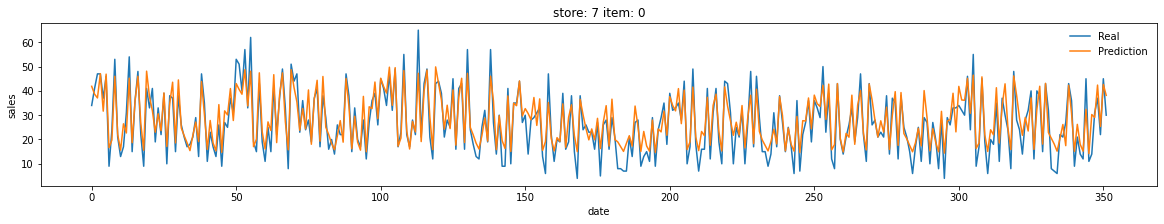

In [51]:
plt.figure(figsize=(20, 3))

plot_predictions(reverse_test, pred_test_all, store=7, item=0)